In [1]:
import sys
sys.path.append('../')
from AFFIRM import *


In [2]:
data_path = '/media/tina/Seagate Expansion Drive/Work/hirid/'
label_name = 'AF'
affirm = AFFIRM(data_path, label_name)

In [3]:
preprocess_params = {
    'rename_dict' : {'temp':'Temperature','mean.arterial.pressure':'MAP','systolic.arterial.pressure':'Systolic BP',
               'diastolic.arterial.pressure':'Diastolic BP'},
    'parameter_dict' : {'Circadian_rhythm': [4, 10]},
     
    'filter_range': [0.01, 0.99]
}
affirm.fit_preprocess(**preprocess_params)
# affirm.preprocess()

In [4]:
prepare_params = {
    'predict_hours': 6,                 
    'grouping_hours': 1,
    'group_how_list': ['max'],#,'min'],
    'group_label_within':120, 
    'rolling': False,
    'take_first': False,
    'percentage_patients_per_variable': 0.8, 
    'avg_values_each': 2,
    'feature_names': [],
    'pharma_quantile' : 0.75,
    'include_patients':[],
    'exclude_patients': [],#'Surgical Cardiovascular'
    
}
affirm.fit_prepare(**prepare_params)
# affirm.prepare()

In [5]:
def create_keras():  
    model = Sequential()
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(curve="PR", name='auprc')])        
    return model

keras_model = create_keras()
keras_model = KerasClassifier(build_fn= create_keras, verbose=0)
keras_model._estimator_type = "classifier"
predict_params = {
    'models': {
#         'Logistic Regression': LogisticRegression(random_state=0)
#           , 'Keras':keras_model,
#           'Random Forest':RandomForestClassifier(max_depth=4, random_state=0),
#             'LightGBM':lgb.LGBMClassifier(boosting_type='gbdt', objective='binary'),
#         'Optimised XGBoost': xgb.XGBClassifier(base_score=0.5, 
#                                                   colsample_bylevel=1, 
#                                                   colsample_bytree=1,
#                                                   gamma=0, 
#                                                   learning_rate=0.1, 
#                                                   max_delta_step=0, 
#                                                   max_depth=10,
#                                                   min_child_weight=1, 
#                                                   n_estimators=100, 
#                                                   nthread=-1,
#                                                   objective='binary:logistic', 
#                                                   reg_alpha=0, 
#                                                   reg_lambda=1,
#                                                   scale_pos_weight=1, 
#                                                   eval_metric = 'aucpr',
#                                                   seed=0, 
#                                                   missing = 1,
#                                                   subsample=1,
#                                                   use_label_encoder=False), 
        'XGBoost': xgb.XGBClassifier(objective = "binary:logistic",
           eval_metric = "aucpr",use_label_encoder=False)
         },
    'colors' : {'LightGBM': '#4e8542',# dark green
          'Baseline': '#ff9292', #pink
          'Logistic Regression':'#eccd1c', #gold
          'Random Forest': '#6aa4c8', #sky blye
          'XGBoost': '#ff833c', #organ
            'Optimised XGBoost': '#fcaf83',
          'Keras': '#8dd8d3' #light blue
         },
    'n_splits': 2,
    'keep_top_features': 20,
    'intervention_features': ['Potassium', 'Magnesium']
     
}
affirm.fit_predict(**predict_params)

In [6]:
obs_variables = pd.Series(affirm.obs_variables).str.replace('_max','').values # 

In [7]:
top_features = ['age', 'Heart_rate', 'patient', 'bmi', 'sex',
'Respiratory_rate', 'MAP', 'Infusion_of_saline_solution', 'Diastolic BP',       
'Systolic BP', 'Peripheral_oxygen_saturation',
'Glasgow_Coma_Score_verbal_response_subscore',       
'Fluid_balance', 'Richmond_agitationsedation_scale',       
'Oxygen_administration_by_nasal_cannula', 'Lactate_Massvolume_in_Arterial_blood',   
'Glucose_Molesvolume_in_Serum_or_Plasma',
'CarboxyhemoglobinHemoglobintotal_in_Arterial_blood',
'Hourly_urine_volume','Glasgow_Coma_Score_eye_opening_subscore']

In [8]:
top_features = list(set(top_features).intersection(set(obs_variables)))

In [9]:
top_features

['Heart_rate',
 'Glasgow_Coma_Score_verbal_response_subscore',
 'Infusion_of_saline_solution',
 'Peripheral_oxygen_saturation',
 'MAP',
 'Glasgow_Coma_Score_eye_opening_subscore',
 'CarboxyhemoglobinHemoglobintotal_in_Arterial_blood',
 'Fluid_balance',
 'Diastolic BP',
 'Respiratory_rate',
 'Systolic BP',
 'Richmond_agitationsedation_scale',
 'Lactate_Massvolume_in_Arterial_blood',
 'Oxygen_administration_by_nasal_cannula',
 'Hourly_urine_volume',
 'Glucose_Molesvolume_in_Serum_or_Plasma']

In [10]:
F = []
for Nfile in range(10):
    df = pd.read_parquet(affirm.preprocessed_path + f'observation_tables/part-{Nfile}.parquet')

    pharma_df = pd.read_parquet(affirm.preprocessed_path + f'pharma_records/part-{Nfile}.parquet')

    if len(affirm.exclude_patients) != 0 or len(affirm.include_patients) != 0:
        df = affirm.include_exclude_patients(df)
    df, pharma_df = affirm.variable_chooser(df, pharma_df)
    df = affirm.prepare_labels(df)

    df = df[top_features + ['AF']]
    df = affirm.add_missingness_flag(df, top_features)
    F.append(df)
df = pd.concat(F)

In [11]:
pids = list(df.reset_index().patientid.unique())

keep_variables = df.drop(columns = ['AF']).columns
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 0)#, add_indicator = True)

df[keep_variables] = imputer.fit_transform(df[keep_variables].values)
train_pids, test_pids = train_test_split(pids, random_state=42, test_size=0.2,shuffle = True)#, stratify = df.groupby('patientid').AF.max())

temporal_train = df.loc[train_pids,:].sort_index()
temporal_test = df.loc[test_pids,:].sort_index()
scaler = StandardScaler()
temporal_train[keep_variables]  = scaler.fit_transform(temporal_train[keep_variables])
temporal_test[keep_variables] = scaler.transform(temporal_test[keep_variables])

In [12]:
def get_pids(df):
    return list(df.reset_index().patientid.unique())

In [13]:
def get_X_y_temporal(df,grouping_hours):
    grouping_hours = int(grouping_hours * 60/5) # need this is 5 minutes
    keep_variables = list(df.drop(columns = ['AF'], errors = 'ignore').columns.values)
    X = np.array([], dtype=np.float64).reshape(0,grouping_hours,len(keep_variables))
    y = []
    pids = get_pids(df)
    groups = {}
    for pid in pids:
        pat_df= df.loc[pid] 
        pat_X = np.array([pat_df[i - grouping_hours:i][keep_variables].values for i in range(grouping_hours, len(pat_df),grouping_hours)])#,n)])
#         print(pat_X.shape)
        pat_y = [pat_df.iloc[i].AF for i in range(grouping_hours, len(pat_df), grouping_hours)]#,n)]) include n to prevent overlap change len(pat_df) to pat_df.index.max() for hourly
        try: 
            X = np.concatenate((X,pat_X),axis = 0)
            y += pat_y
            groups[pid] = pat_X.shape[0]
        except:
            pass
    y = np.array(y).reshape(-1,1)
    return X, y, groups

def get_X_y_temporal(df,grouping_hours):
    grouping_hours = int(grouping_hours * 60/5) # need this is 5 minutes
    keep_variables = list(df.drop(columns = ['AF'], errors = 'ignore').columns.values)
    X = np.array([], dtype=np.float64).reshape(0,grouping_hours,len(keep_variables))
    y = []
    pids = get_pids(df)
    groups = {}
    for pid in pids:
        pat_df= df.loc[pid] 
        pat_X = np.array([pat_df[i - grouping_hours:i][keep_variables].values for i in range(grouping_hours, len(pat_df),5)])#,n)])
#         print(pat_X.shape)
        pat_y = [pat_df.iloc[i].AF for i in range(grouping_hours, len(pat_df),5)]#,n)]) include n to prevent overlap change len(pat_df) to pat_df.index.max() for hourly
        try: 
            X = np.concatenate((X,pat_X),axis = 0)
            y += pat_y
            groups[pid] = pat_X.shape[0]
        except:
            pass
    y = np.array(y).reshape(-1,1)
    return X, y, groups

X_train, y_train, train_groups =  get_X_y_temporal(temporal_train,2)
X_test, y_test, test_groups =  get_X_y_temporal(temporal_test,2)

In [14]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential,Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense, Dropout,concatenate
from tcn import TCN
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve,average_precision_score,f1_score,auc,confusion_matrix

model = Sequential()
model.add(TCN(kernel_size=6, dilations=[1, 2, 4, 8, 16],input_shape= (X_train.shape[1],X_train.shape[2])))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
checkpoint = ModelCheckpoint('weights.h5', monitor='get_f1',save_best_only=True, verbose=2)
early_stopping = EarlyStopping(monitor='get_f1', patience=5)

history = model.fit(
    X_train, y_train,
    batch_size=512, 
    epochs=10,
    validation_split=0.1)#, 
    #callbacks=[early_stopping, checkpoint])

model.evaluate(X_test,y_test)


Epoch 1/10
238/238 [==============================] - 36s 148ms/step - loss: 0.3560 - val_loss: 0.4419
Epoch 2/10
238/238 [==============================] - 37s 155ms/step - loss: 0.2784 - val_loss: 0.4428
Epoch 3/10
238/238 [==============================] - 37s 157ms/step - loss: 0.2641 - val_loss: 0.4913
Epoch 4/10
238/238 [==============================] - 37s 156ms/step - loss: 0.2522 - val_loss: 0.5197
Epoch 5/10
238/238 [==============================] - 37s 156ms/step - loss: 0.2394 - val_loss: 0.4481
Epoch 6/10
238/238 [==============================] - 37s 157ms/step - loss: 0.2291 - val_loss: 0.4831
Epoch 7/10
238/238 [==============================] - 38s 158ms/step - loss: 0.2155 - val_loss: 0.5787
Epoch 8/10
238/238 [==============================] - 38s 159ms/step - loss: 0.2006 - val_loss: 0.6214
Epoch 9/10
238/238 [==============================] - 38s 159ms/step - loss: 0.1865 - val_loss: 0.6198
Epoch 10/10
1144/1144 [==============================] - 4s 3ms/step - lo

0.38674864172935486

In [15]:
def calc_auprc(y_test,y_pred):
    precision,recall,  _ = precision_recall_curve(y_test, y_pred) # calculate recall and precision
    AUPRC = auc(recall, precision) # calculate area under the precision-recall curve
    return AUPRC

In [16]:
y_pred = model.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
calc_auprc(y_test,y_pred)

0.18549333030574416

In [17]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

<AxesSubplot:>

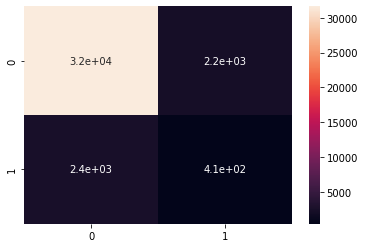

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)